In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
                'marital-status', 'occupation', 'relationship', 'race', 'gender',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']


adult_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

adult_test_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier

from joblib import dump, load
from sklearn.model_selection import cross_val_score
import sys
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
def adult_preprocess(df, balanced=False, impute=False):
    """adult_preprocess(df, balanced=False, impute=False)
            balanced: will sample an even amount of data from each
    
            impute:
                Imputes missing data using random forest,
                or removes rows with missing data
                
        expands categorical data returns X and Y arrays"""
    #drop columns
    drop_columns = ["fnlwgt"]
    df = df.drop(drop_columns , axis=1)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import tree
    
    
    if impute:
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.workclass
        impute_df.drop(columns = ['workclass'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.workclass.values == '?')].copy()
        
        train_data = impute_df[(df.workclass.values != '?')].copy()
        train_label = impute_labels[(df.workclass.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.workclass.values == '?'),'workclass'] = random_forest_pred
        
        #repeat for occupation
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.occupation
        impute_df.drop(columns = ['occupation'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.occupation.values == '?')].copy()
        
        train_data = impute_df[(df.occupation.values != '?')].copy()
        train_label = impute_labels[(df.occupation.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.occupation.values == '?'),'occupation'] = random_forest_pred
        
        # repeat for native-country
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df['native-country']
        impute_df.drop(columns = ['native-country'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df['native-country'].values == '?')].copy()
        
        train_data = impute_df[(df['native-country'].values != '?')].copy()
        train_label = impute_labels[(df['native-country'].values != '?')]
     
        random_forest = tree.DecisionTreeClassifier()
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df['native-country'].values == '?'),'native-country'] = random_forest_pred    
    else:
        # remove rows with '?'s
        df = df[(df != '?').all(1)]
    
    # convert categorical data into one-hot
    df_one_hot = pd.get_dummies(df)
    
    # sample equal number of plus and minus
    if balanced:
        # find number of income > $50k
        sample_number = len(df_one_hot[df_one_hot['income_>50K'] == 1])
        df_over_50k = df_one_hot[df_one_hot['income_>50K'] == 1].sample(n=sample_number, random_state=0)
        df_under_50k = df_one_hot[df_one_hot['income_>50K'] == 0].sample(n=sample_number, random_state=0)
        frames = [df_over_50k, df_under_50k]
        df_clean = pd.concat(frames)
    else:
        df_clean = df_one_hot
    
    #randomize data order
    df_clean = df_clean.sample(frac=1)
    
    # split into inputs and targets
    X = df_clean.iloc[:,0:-2].values
    Y = df_clean.loc[:,'income_>50K'].values
    
    return X, Y

In [50]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

In [7]:
X, Y = adult_preprocess(adult_df, balanced=False, impute=True)
scaler = StandardScaler()  # Default behavior is to scale to [0,1]
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_test, Y_test = adult_preprocess(adult_test_df, balanced=False, impute=True)
X_test = scaler.fit_transform(X_test)


## Decision tree

Max is at 0.01000: 0.86 


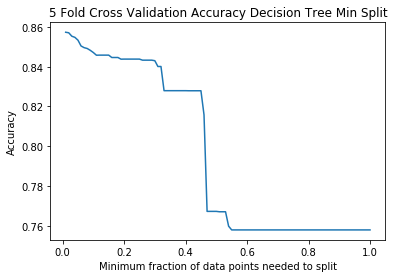

In [48]:
min_samples_splits = np.linspace(0.01, 1.0, 100, endpoint=True)

min_samples_leaf = 1
acc = np.zeros(100)
i = 0
for split in min_samples_splits:
        clf = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = split,
                              min_samples_leaf = min_samples_leaf)
        scores = cross_val_score(clf, X_train, Y_train, cv=5)
#         print("Accuracy with a min_samples %0.5f: %0.2f (+/- %0.2f)" % (split ,scores.mean(), scores.std() * 2))
        acc[i] = scores.mean()
        i += 1
        sys.stdout.flush()
        
index = np.argmax(acc)

print("Max is at %0.5f: %0.2f " % (min_samples_splits[index], acc[index]))

plt.plot(min_samples_splits,acc)
plt.xlabel("Minimum fraction of data points needed to split")
plt.ylabel("Accuracy")
plt.title("5 Fold Cross Validation Accuracy Decision Tree Min Split")
plt.savefig("minSplit.png")

Accuracy with a min_leafs 0.10000: 0.82 (+/- 0.00)
Accuracy with a min_leafs 0.20000: 0.81 (+/- 0.01)
Accuracy with a min_leafs 0.30000: 0.76 (+/- 0.00)
Accuracy with a min_leafs 0.40000: 0.76 (+/- 0.00)
Accuracy with a min_leafs 0.50000: 0.76 (+/- 0.00)
Max is at 0.10000: 0.82 


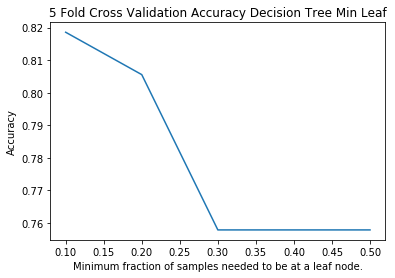

In [47]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
# min_samples_leaf = 1
split = 0.1
acc = np.zeros(5)
i = 0
for leafs in min_samples_leafs:
        clf = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = split,
                              min_samples_leaf = leafs)
        scores = cross_val_score(clf, X_train, Y_train, cv=5)
        print("Accuracy with a min_leafs %0.5f: %0.2f (+/- %0.2f)" % (leafs ,scores.mean(), scores.std() * 2))
        acc[i] = scores.mean()
        i += 1
        sys.stdout.flush()

index = np.argmax(acc)

print("Max is at %0.5f: %0.2f " % (min_samples_leafs[index], acc[index]))
plt.plot(min_samples_leafs,acc)
plt.xlabel("Minimum fraction of samples needed to be at a leaf node.")
plt.ylabel("Accuracy")
plt.title("5 Fold Cross Validation Accuracy Decision Tree Min Leaf")
plt.savefig("minLeaf.png")

In [52]:
min_samples_split = 0.01 #default value
min_samples_leaf = 0.1  # default value
# results = dic()
# gini tree

g_tree = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf)

g_tree.fit(X_train,Y_train)

g_train_predict = g_tree.predict(X_train)
g_test_predict = g_tree.predict(X_test)

DTree_Gini = model_eval(Y_train,g_train_predict)
DTree_Entropy = model_eval(Y_train,g_test_predict)





ovl_dtree = round(pd.DataFrame([DTree_Entropy, DTree_Gini], index = ['DTree_Entropy','DTree_Gini']),4)

display(ovl_dtree)

# entropy tree

# e_tree = DecisionTreeClassifier(criterion = 'entropy', 
#                               min_samples_split = min_samples_split,
#                               min_samples_leaf = min_samples_leaf)

# e_tree.fit(X_train,Y_train)
# e_train_predict = e_tree.predict(X_train)
# e_test_predict = e_tree.predict(X_test)

KeyError: u'the label [>50K] is not in the [index]'

## Random Forest

Max is at 1.00000: 0.86 


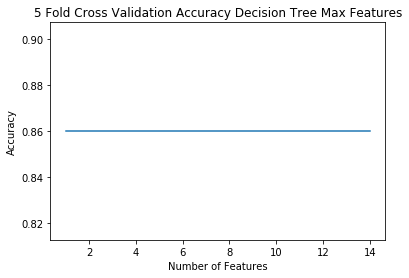

In [45]:
n_features = np.linspace(1, 14, 14, endpoint=True)

min_samples_split = 0.01 #value found in decision tree
min_samples_leaf = 0.1  # value found in decision tree
min_samples_leaf = 1
split = 0.1
acc = np.zeros(14)
i = 0
for features in n_features:
        clf = RandomForestClassifier(n_estimators = 10,
                                criterion = 'gini', 
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf,
                               max_features = None)
        scores = cross_val_score(clf, X_train, Y_train, cv=5)
#         print("Accuracy with a min_leafs %0.5f: %0.2f (+/- %0.2f)" % (features ,scores.mean(), scores.std() * 2))
        acc[i] = round(scores.mean(),2)
        i += 1
        sys.stdout.flush()
        
print("Max is at %0.5f: %0.2f " % (n_features[index], acc[index]))
plt.plot(n_features,acc)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("5 Fold Cross Validation Accuracy Decision Tree Max Features")
plt.savefig("maxFeatures.png")

In [15]:
min_samples_split = 0.01 #value found in decision tree
min_samples_leaf = 0.1  # value found in decision tree
n_estimators = 10 # default
bootstrap = False
# gini tree

for n_estimators in range(10,100,10):
    
    g_tree = RandomForestClassifier(n_estimators = n_estimators,
                                    criterion = 'gini', 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                   max_features = None,
                                   bootstrap = bootstrap)

    g_tree.fit(X_train,Y_train)


    predict_train_gini = g_tree.predict(X_train)
    
    predict_test_gini = g_tree.predict(X_test)

    
    

    # entropy tree


    e_tree = RandomForestClassifier(n_estimators = n_estimators,
                                    criterion = 'entropy', 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                   max_features = None,
                                   bootstrap = bootstrap)



    e_tree.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)